In [1]:
import os
import numpy as np
import dpdata
import ase 
import ase.io
from matplotlib import pyplot as plt
from fse.systems import perovskite
import matplotlib as mpl
import matplotlib.cm     as cm

mpl.rcParams['axes.linewidth'] = 2.0 #set the value globally
mpl.rcParams['lines.linewidth'] = 2.0
mpl.rcParams['lines.linestyle'] = 'dashed'
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.marker'] = 'o'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 15

mycmap = cm.plasma


system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T400_ss15 loaded -- 112 frames
T=400, Mean(|dipole|)=3.171837662999396, std=0.35458660570713924
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T500_ss15 loaded -- 112 frames
T=500, Mean(|dipole|)=3.0268617290341693, std=0.4093505294449484
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T600_ss15 loaded -- 112 frames
T=600, Mean(|dipole|)=2.8698794649494843, std=0.46437352453016695
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T700_ss15 loaded -- 112 frames
T=700, Mean(|dipole|)=2.6511763396323387, std=0.5227082120663689
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T750_ss15 loaded -- 112 frames
T=750, Mean(|dipole|)=2.5131959412872877, std=0.5575750063658701
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T80

Text(0, 0.5, '$\\langle |p|\\rangle$ [eA]')

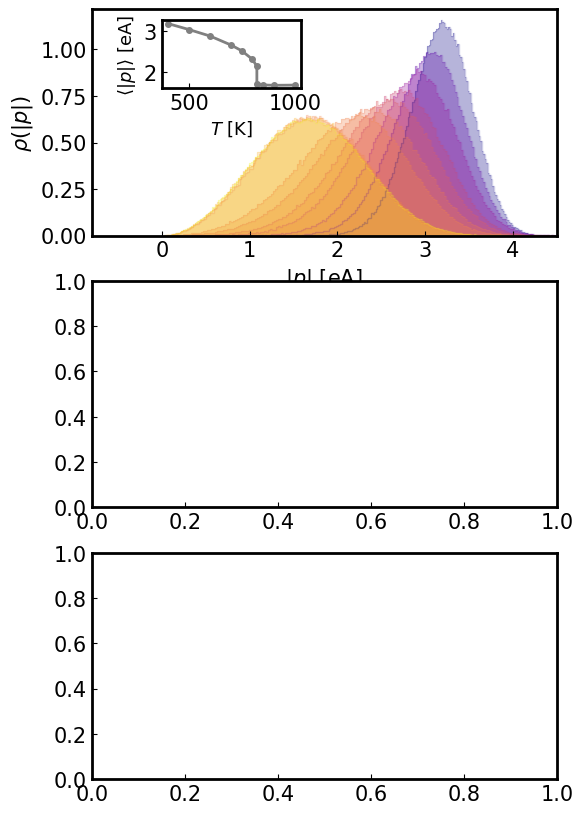

In [2]:

temp_list =   [   400, 500, 600, 700, 750, 800, 820.99, 821.01,  850,  900, 1000  ]
ss = 15
throw = 100
ncell = ss**3
dipole_average = []
fig,ax = plt.subplots(3,1, figsize = (6, 10))
for ii, temp in enumerate(temp_list):
    folder = '/home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T{}_ss{}'.format(temp, ss ) 
    pto_factory = perovskite(ABO3=['He','Li','H'], born_charges=[3.7140, 5.4879, -3.3551, -2.9234])
    ##### load data #####
    data_file = os.path.join(folder, 'dipole.npy')
    if os.path.exists(data_file):
        dipole_list = np.load(data_file)
        print('system {} loaded -- {} frames'.format(folder, dipole_list.shape[0]))
    else:
        from deepmd.infer import DeepDipole # use it to load your trained model
        model = DeepDipole('/home/pinchenx/tigress/DPModels/PTO-MODEL_DEV/m0/dipole-compress.pb')
        ase_atoms = ase.io.read(os.path.join(folder,'pto.lammpstrj'),format = 'lammps-dump-text',index=':')
        lattice = pto_factory.get_effective_lattice([ss,ss,ss], ase_atoms[0], central_element='Li')
        print('Found lattice')
        print('system {} loaded -- {} frames'.format(folder, nframe))
        atypes = ase_atoms[0].get_atomic_numbers()-1
        dipole_list = []
        for idx in range(throw, len(ase_atoms)):
            dipole = pto_factory.get_lattice_dipole( model, atypes, ase_atoms[idx], lattice )
            dipole_list.append(dipole)
        dipole_list = np.array(dipole_list)
        np.save(os.path.join(folder, 'dipole.npy'), dipole_list)
    nframe = dipole_list.shape[0]
    ##### process data #####
    dipole_dist = []
    fluc2_list  = []
    for idx in range( nframe):
        dipole = dipole_list[idx]
        global_dipole = dipole.mean((0,1,2))
        global_order = ((global_dipole**2).sum())**0.5
        # print('=======frame={}, global dipole={}====='.format(idx, global_dipole))
        dipole2 =  (dipole.mean((0,1,2))**2).sum(-1)
        fluc2 = (dipole*dipole).sum(-1).mean()  -  dipole2
        dipole_dist.append(((dipole**2).sum(-1))**0.5)
        fluc2_list.append(fluc2)
    dipole_dist = np.concatenate(dipole_dist).flatten()
    dipole_average.append(dipole_dist.mean())
    print('T={}, Mean(|dipole|)={}, std={}'.format(temp,dipole_dist.mean(), dipole_dist.std() ))
    fluc2_list  = sum(fluc2_list) / len(fluc2_list)
    alpha = 0.3 if temp <821 else 0.2
    ax[0].hist(dipole_dist, bins=200, histtype='bar', 
                color=mycmap((temp-temp_list[0])/(temp_list[-1]-temp_list[0])),
                alpha=alpha, density=True, label='T={}'.format(temp) )
    ax[0].hist(dipole_dist, bins=200, histtype='step', 
            color=mycmap((temp-temp_list[0])/(temp_list[-1]-temp_list[0])), 
            alpha=0.2, linewidth=1, density=True, label='T={}'.format(temp) ) 

ax[0].set_xlabel(r'$|p|$ [eA] ')
ax[0].set_ylabel(r'$\rho(|p|)$')
ax[0].set_xlim(-0.8, 4.5)
# ax[0].text(0.08, 0.2, r'$L=15$', transform=ax[0].transAxes, fontsize=13,#fontdict=text_font,
    # verticalalignment='top')

inset_loc = [0.15, 0.65, 0.3, 0.3]
ins = ax[0].inset_axes(inset_loc)
ins.plot(temp_list, dipole_average, color = 'grey',  markersize=4, linestyle='solid')
ins.set_xlabel(r'$T$ [K]', fontsize=13)
ins.set_ylabel(r'$\langle |p|\rangle$ [eA]', fontsize=13)



In [3]:

for ii, temp in enumerate(temp_list):
    folder = '/home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T{}_ss{}'.format(temp, ss ) 
    pto_factory = perovskite(ABO3=['He','Li','H'], born_charges=[3.7140, 5.4879, -3.3551, -2.9234])
    ##### load data #####
    data_file = os.path.join(folder, 'dipole.npy')
    dipole_list = np.load(data_file)
    print('system {} loaded -- {} frames'.format(folder, dipole_list.shape[0]))
    ##### process data #####
    # order_list =[]
    corr_ferr_long = 0
    corr_ferr_tran = 0
    corr_para = 0
    # dipole_dist = []
    # fluc2_list  = []
    for idx in range( nframe):
        dipole = dipole_list[idx]  # (Lx,Ly,Lz, 3)
        dipole2 =  (dipole.mean((0,1,2))**2).sum(-1)
        fluc2 = (dipole*dipole).sum(-1).mean()  
        c_dir, b_dir,a_dir = 2, 1, 0
        corr_long =[]
        corr_tran =[]
        pair_corr = 0
        for d in range(6):
            corr_c = ((dipole*np.roll(dipole, d, c_dir)).sum(-1).mean()  ) / fluc2  ###   <dp_x, dp_x+d>/<dp_x,dp_x>
            corr_a = ((dipole*np.roll(dipole, d, a_dir)).sum(-1).mean()  ) / fluc2
            corr_b = ((dipole*np.roll(dipole, d, b_dir)).sum(-1).mean()  ) / fluc2
            corr_long.append(corr_c)
            corr_tran.append((corr_a ))
            # print('distance={}, corr_long={},corr_trans={}'.format(d, corr_c,corr_a))
        if temp < 821:
            corr_ferr_long += np.array(corr_long) / nframe
            corr_ferr_tran += np.array(corr_tran)  / nframe
            # dipole_ferr_dist.append(((dipole**2).sum(-1))**0.5)
            # fluc2_ferr.append(fluc2)
            pair_corr = corr_ferr_tran
        else:
            corr_para += np.array(corr_tran) / nframe 
            # dipole_para_dist.append(((dipole**2).sum(-1))**0.5)
            # fluc2_para.append(fluc2)
            pair_corr = corr_para
    ax[1].plot(pair_corr, 
        color=mycmap((temp-temp_list[0])/(temp_list[-1]-temp_list[0]))
        ,label=r' T={}K'.format(temp) )

    # ax[0].plot(corr_ferr_tran,label=r'Ferro Phase; Transverse, T={}K'.format(temp) )
    # ax[1].plot(corr_para,label=r"Para Phase; , T={}K ".format(temp) )
    # ax[0].set_xlabel('d [Unit Distance] ')
    # ax[0].set_ylabel(r'$<\Delta P_i\cdot\Delta P_{i+d}>/<\|\Delta P_i\|^2>$')
    # ax[1].set_xlabel('d [Unit Distance] ')
    # ax[1].set_ylabel(r'$<\Delta P_i\cdot\Delta P_{i+d}>/<\|\Delta P_i\|^2>$')
# ax.legend(frameon=False)
ax[1].text(0.4, 0.54, r'$\uparrow$ $T=821$K, [001] Ferro ', transform=ax[1].transAxes, fontsize=13,#fontdict=text_font,
    verticalalignment='top')
ax[1].text(0.5, 0.22, r'$\downarrow$ $T=821$K, Para', transform=ax[1].transAxes, fontsize=13,#fontdict=text_font,
    verticalalignment='top')
ax[1].set_xlabel(r'$|d_{ij}|$')
ax[1].set_ylabel(r'$\langle p_i\cdot p_{j}\rangle/\langle\|p_i\|^2\rangle$')
# sm = plt.cm.ScalarMappable(cmap=mycmap, norm=plt.Normalize(vmin=temp_list[0], vmax=temp_list[-1]))
# cb = fig.colorbar(sm)
# cb.set_label( label=r'$T$[K]' )


system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T400_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T500_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T600_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T700_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T750_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T800_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T820.99_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/check_dipole_distribution/data/T821.01_ss15 loaded -- 112 frames
system /home/pinchenx/data.gpfs/ferro_scratch/PTO/DPMD/che

Text(48.125, 0.5, '$\\langle p_i\\cdot p_{j}\\rangle/\\langle\\|p_i\\|^2\\rangle$')

In [4]:
from ase.geometry.analysis import Analysis

ss = 15
# dt = 5ps

rmax=5
nbins=500
distance = np.linspace(0,rmax,nbins+1)[:-1]
distance += (distance[1] - distance[0])/2
for temp in [300, 820,822, 900]:
    rdf = np.load('T{}L{}_rdf.npy'.format(temp, ss))
    if temp == 820:
        label = r'$T=T_c-1$K'
    elif temp == 822:
        label = r'$T=T_c+1$K'
    else:
        label = r'$T={}$K'.format(temp)
    ax[2].plot(distance[distance > 3], rdf[distance > 3], label=label, 
               markersize=0, linewidth=2, linestyle='solid')

ax[2].legend()
ax[2].set_xlabel('r[A]')
ax[2].set_ylabel('g(r)')


Text(48.125, 0.5, 'g(r)')

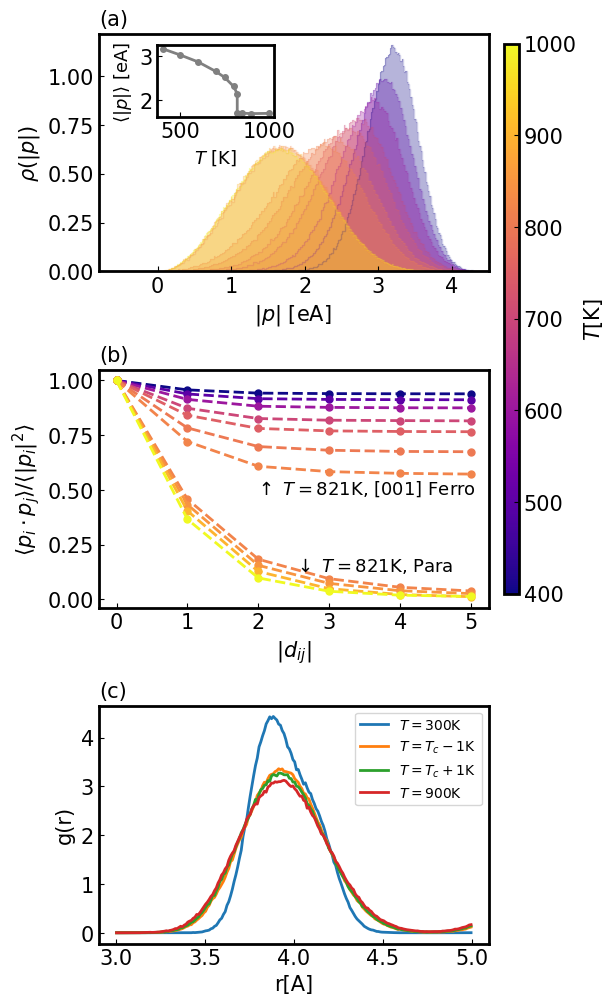

In [5]:

ax[0].set_title('(a)',loc='left', fontsize=15)
ax[1].set_title('(b)',loc='left', fontsize=15)
ax[2].set_title('(c)',loc='left', fontsize=15)

fig.tight_layout()
fig.subplots_adjust(left=0.15, right=0.8, top=0.96, bottom=0.05)
cbar_ax = fig.add_axes([0.825, 0.4, 0.025, 0.55])
sm = plt.cm.ScalarMappable(cmap=mycmap, norm=plt.Normalize(vmin=temp_list[0], vmax=temp_list[-1]))
cb = fig.colorbar(sm,  cax=cbar_ax)
cb.set_label( label=r'$T$[K]' )

fig.savefig('disorder.png', dpi=300)
fig
